## DOM MODEL
blame: BANA7075 Group 1

In [8]:
#Run these seperately
#pip install mlflow
#pip install pandas
#pip install sklearn

In [24]:
#import modules and functions

import mlflow
from mlflow.models import infer_signature

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, r2_score, root_mean_squared_error

In [12]:
# Load the CSV from filepath

folder_path = r'C:\BANA7075 Final Project\csv Merged Data'  # or replace with your target folder

# Prefix you're looking for
prefix = 'hamilton'

files = os.listdir(folder_path)
csv_files = [f for f in files if f.startswith(prefix) and f.endswith('.csv')]

if csv_files:
    file_path = os.path.join(folder_path, csv_files[0])
    print(f"Loaded: {file_path}")
else:
    print("No matching CSV files found.")


Loaded: C:\BANA7075 Final Project\csv Merged Data\hamilton_zip_merge__hamilton_20250422_222639__redfin_20250422_222948__created_20250422_233455.csv


In [84]:
#Feature Engineering

#Load data
df = pd.read_csv(file_path)

#Define target and features
target = 'Estimated_Days_On_Market'  # replace with actual column name
planned_features = ['saleamount','Year Built', '# Bedrooms', '# Full Bathrooms','# Half Bathrooms','Acreage', 'Finished Square Footage', 'Basement Type']
df = df.dropna(subset=planned_features) #drop incomplete rows
df = df.dropna(subset=[target]) #drop incomplete rows

current_year = 2025
df['Age of Home'] = current_year - df['Year Built']

mean_age = df['Age of Home'].mean()
std_dev_age = np.std(df['Age of Home'])
df['Age_stability_score'] = np.exp(-((df['Age of Home'] - mean_age)**2) / (2 * (1.5*std_dev_age**2)))
df['Age_stability_score'] = (df['Age_stability_score']-1)*-1



# - OUTLIERS FILTERS - ######################################################################################
Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 2.0 * IQR
upper_bound = Q3 + 2.0 * IQR

# Filter the DataFrame
df = df[(df[target] >= lower_bound) & (df[target] <= upper_bound)]

Q1 = df['saleamount'].quantile(0.25)
Q3 = df['saleamount'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 2.5 * IQR
upper_bound = Q3 + 2.5 * IQR

# Filter the DataFrame
df = df[(df['saleamount'] >= lower_bound) & (df['saleamount'] <= upper_bound)]
################################################################################################################

X = df.drop(columns=[target]) #drop the target row 
y = df[target] #create a y value with target column
#print(X.columns)

#Basement Type Encoded
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Fit and transform the column (needs to be 2D)
encoded = encoder.fit_transform(X[['Basement Type']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Basement Type']))
encoded_df.index = X.index
X = pd.concat([X.drop(columns=['Basement Type']), encoded_df], axis=1)
#print(X.columns)
#Combine Bathrooms into one number
X['# Bathrooms'] = X['# Full Bathrooms'] + ((X['# Half Bathrooms'])/2)




features = ['saleamount','Age of Home','Age_stability_score', '# Bedrooms', '# Bathrooms','Acreage', 'Finished Square Footage', 'Basement Type_Full Basement', 'Basement Type_Full Crawl','Basement Type_Part Basement', 'Basement Type_Part Crawl']

X = X[features].select_dtypes(include='number')
print(features)
print(X)

['saleamount', 'Age of Home', 'Age_stability_score', '# Bedrooms', '# Bathrooms', 'Acreage', 'Finished Square Footage', 'Basement Type_Full Basement', 'Basement Type_Full Crawl', 'Basement Type_Part Basement', 'Basement Type_Part Crawl']
     saleamount  Age of Home  Age_stability_score  # Bedrooms  # Bathrooms  \
0        550000         74.0             0.035401         3.0          3.0   
5        470000         63.0             0.145184         3.0          2.5   
13       306000         73.0             0.042579         3.0          1.0   
15       370000         66.0             0.109063         3.0          2.0   
16       310000         54.0             0.273116         4.0          2.5   
..          ...          ...                  ...         ...          ...   
689      113000         97.0             0.056578         3.0          2.0   
691      644689         25.0             0.707320         3.0          2.5   
692      310000         44.0             0.432150         2.

In [85]:
# features = ['Year Built 6', '# Bedrooms 8', '# Bathrooms 7','Acreage 4', 'Finished Square Footage 7', 'Basement Type_Full Basement 5', 'Basement Type_Full Crawl 3', 'Basement Type_None 3', 'Basement Type_Part Basement 3', 'Basement Type_Part Crawl 3']
print(X.shape[0])

366


In [80]:
#This is where the model models

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Define the model hyperparameters
params = {
    "random_state": 42,
    "max_depth": 5,
    "min_samples_leaf": 40,
}

#Create a pipeline: scale features and train a decision tree regressor
model = Pipeline(steps=[('regressor', DecisionTreeRegressor(**params))])

#Train the model
model.fit(X_train, y_train)

#Predict and evaluate
preds = model.predict(X_val)
mae = mean_absolute_error(y_val, preds)
rmse = root_mean_squared_error(y_val, preds)
r2 = r2_score(y_val, preds)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'r_squared: {r2:.3f}','\n')

print(y_val)
print(preds)

Mean Absolute Error: 6.48
Root Mean Squared Error: 8.32
r_squared: 0.282 

401    43.0
59     65.0
32     48.0
611    40.0
96     61.0
       ... 
152    52.0
170    51.0
400    43.0
608    40.0
450    49.0
Name: Estimated_Days_On_Market, Length: 74, dtype: float64
[59.89855072 59.89855072 52.06666667 51.03448276 51.03448276 59.89855072
 55.125      66.625      55.125      54.525      59.89855072 66.625
 52.06666667 59.89855072 54.525      51.03448276 52.06666667 66.625
 55.125      55.125      52.06666667 54.525      51.03448276 59.89855072
 59.89855072 52.06666667 59.89855072 52.06666667 59.89855072 52.06666667
 51.03448276 51.03448276 59.89855072 55.125      52.06666667 66.625
 51.03448276 66.625      55.125      66.625      66.625      55.125
 52.06666667 54.525      66.625      66.625      59.89855072 59.89855072
 54.525      59.89855072 66.625      59.89855072 59.89855072 59.89855072
 59.89855072 59.89855072 54.525      52.06666667 55.125      59.89855072
 55.125      52.06666667

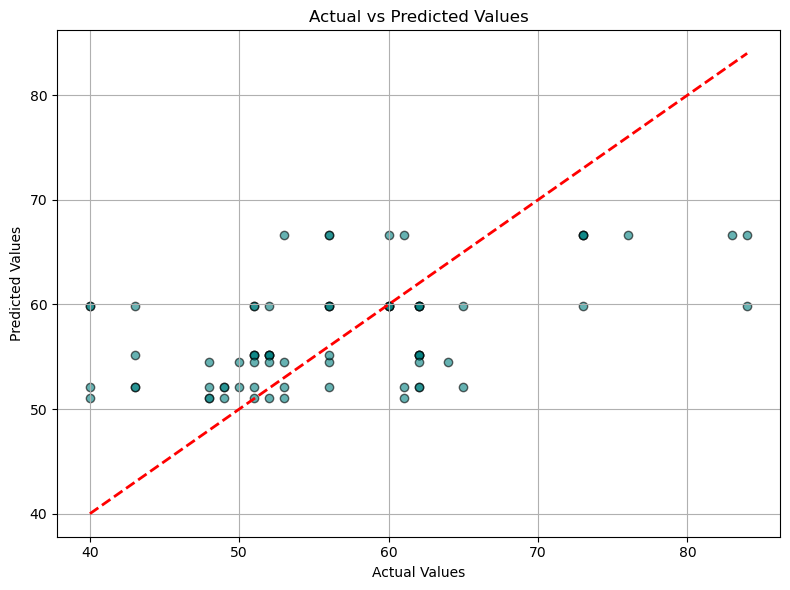

In [81]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_val, preds, alpha=0.6, color='teal', edgecolor='k')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.tight_layout()
plt.show()


# Manual Tuning for DEV ONLY

In [189]:
#regressor = DecisionTreeRegressor(max_depth=8, min_samples_leaf=2, random_state=42)
#
#model = Pipeline(steps=[('regressor', regressor)])
#
#model.fit(X_train, y_train)
#preds = model.predict(X_val)
#mae = mean_absolute_error(y_val, preds)
#print(f'Tuned MAE: {mae:.2f}')
#print(preds)

# Visualizer

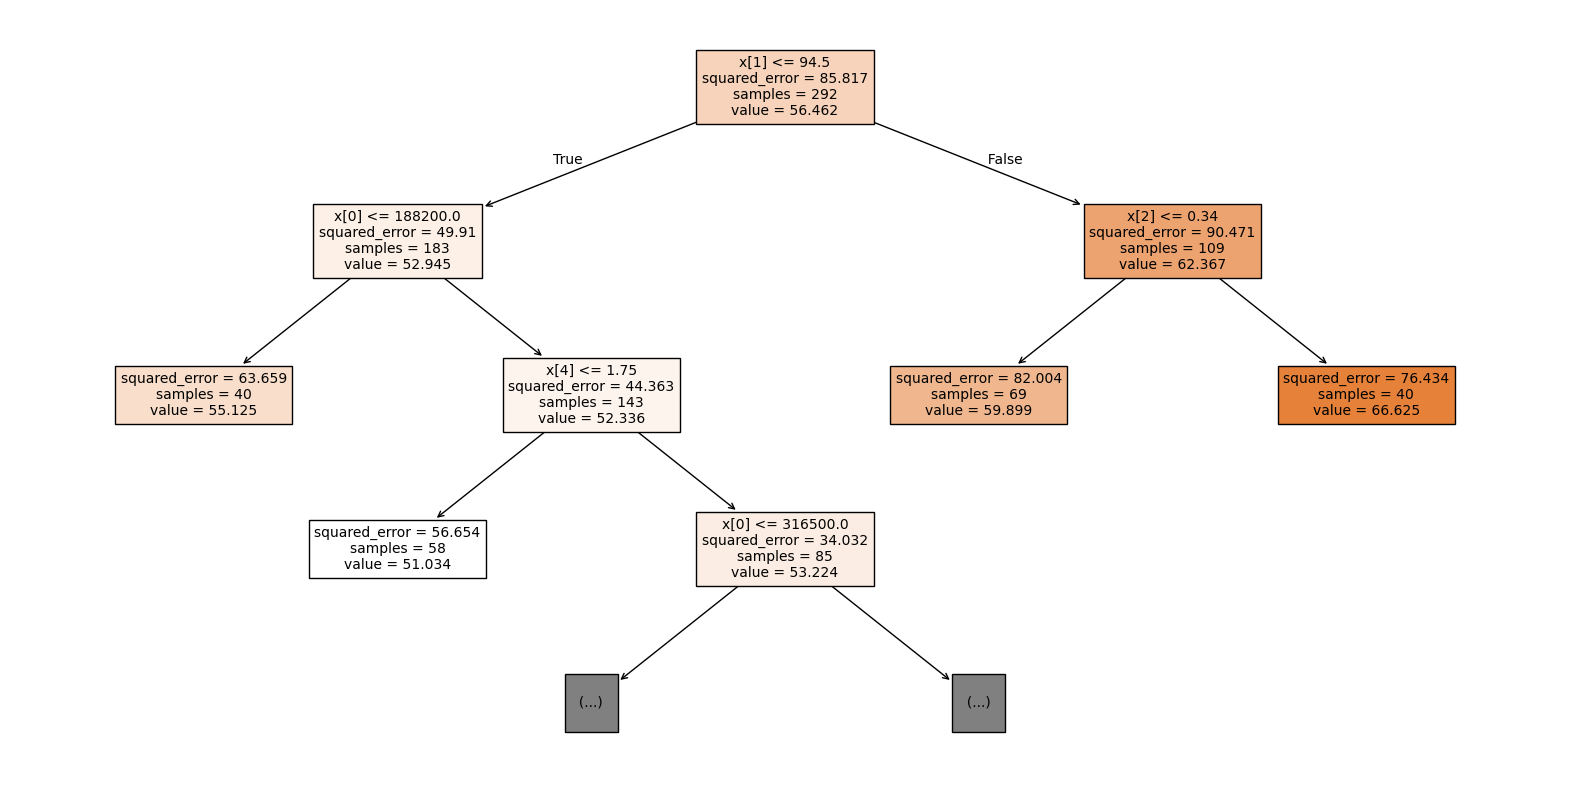

In [82]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Access the trained decision tree from the pipeline
regressor = model.named_steps['regressor']

# Plot it
plt.figure(figsize=(20,10))
plot_tree(
    regressor,
    filled=True,
    fontsize=10,
    max_depth=3  # limit depth for readability
)
plt.show()


# ML Flow Log

In [65]:
mlflow.set_tracking_uri(uri="http://<host>:<port>")

In [83]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# Create a new MLflow Experiment
mlflow.set_experiment("Machine Learning Design Group 1")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("r_squared", r2)
    mlflow.log_metric("Mean Absolute Error", mae)
    mlflow.log_metric("Root Mean Squared Error", rmse)



    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("MVP", "First test of ML Flow with model")

    # Infer the model signature
    signature = infer_signature(X_train, model.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="housing_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="DOM-predictor",
    )

C:\Users\schri\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Registered model 'DOM-predictor' already exists. Creating a new version of this model...
2025/04/23 10:15:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DOM-predictor, version 13


🏃 View run burly-wasp-264 at: http://127.0.0.1:8080/#/experiments/1/runs/d8880bede5024d0aa66cbffe6247ca9f
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


Created version '13' of model 'DOM-predictor'.


# Load the Model

In [29]:
# Load the model back for predictions as a generic Python Function model
loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)

predictions = loaded_model.predict(X_val)

#iris_feature_names = datasets.load_iris().feature_names

result = pd.DataFrame(X_val, columns=features)
result["actual_class"] = y_val
result["predicted_class"] = predictions

result[:4]

,saleamount,Year Built,# Bedrooms,# Bathrooms,Acreage,Finished Square Footage,Basement Type_Full Basement,Basement Type_Full Crawl,Basement Type_Part Basement,Basement Type_Part Crawl,actual_class,predicted_class
401,265000,1928.0,2.0,2.0,0.100,NaN,1.0,0.0,0.0,0.0,43.0,58.000000
59,80000,1929.0,2.0,2.0,0.127,NaN,1.0,0.0,0.0,0.0,65.0,66.076923
32,575000,1992.0,4.0,2.5,0.629,NaN,1.0,0.0,0.0,0.0,48.0,51.800000
611,250000,1967.0,3.0,1.5,0.138,NaN,1.0,0.0,0.0,0.0,40.0,54.282051
